In [1]:
!pip install tensorflow==2.0.0-alpha0  --upgrade
!pip install pillow
!pip install scipy
!pip install opencv-python
!pip install matplotlib


Requirement already up-to-date: tensorflow==2.0.0-alpha0 in ./venv/lib/python3.6/site-packages (2.0.0a0)
Requirement not upgraded as not directly required: astor>=0.6.0 in ./venv/lib/python3.6/site-packages (from tensorflow==2.0.0-alpha0) (0.7.1)
Requirement not upgraded as not directly required: wheel>=0.26 in ./venv/lib/python3.6/site-packages (from tensorflow==2.0.0-alpha0) (0.33.1)
Requirement not upgraded as not directly required: protobuf>=3.6.1 in ./venv/lib/python3.6/site-packages (from tensorflow==2.0.0-alpha0) (3.7.1)
Requirement not upgraded as not directly required: gast>=0.2.0 in ./venv/lib/python3.6/site-packages (from tensorflow==2.0.0-alpha0) (0.2.2)
Requirement not upgraded as not directly required: termcolor>=1.1.0 in ./venv/lib/python3.6/site-packages (from tensorflow==2.0.0-alpha0) (1.1.0)
Requirement not upgraded as not directly required: tb-nightly<1.14.0a20190302,>=1.14.0a20190301 in ./venv/lib/python3.6/site-packages (from tensorflow==2.0.0-alpha0) (1.14.0a20190

In [2]:
import numpy as np
import tensorflow as tf
from IPython.display import display 
import PIL
import scipy
import cv2
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import glob
from matplotlib import pyplot as plt

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import MaxPooling2D
from tensorflow.python.keras.layers import UpSampling2D
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Input
from tensorflow.python import keras as K



In [4]:
def load_images(path):
    image_list = np.zeros((len(path), 100, 100, 1))
    for i, fig in enumerate(path):
        img = K.preprocessing.image.load_img(fig, color_mode='grayscale', target_size=(100, 100))
        x = K.preprocessing.image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

TRAIN_CLEAN = glob.glob('data/train/blur/*.jpg')
TRAIN_DIRTY = glob.glob('data/train/sharp/*.jpg')
TEST = glob.glob('data/test/*.png')

x_train = load_images(TRAIN_CLEAN)
y_train = load_images(TRAIN_DIRTY)
x_test = load_images(TEST)


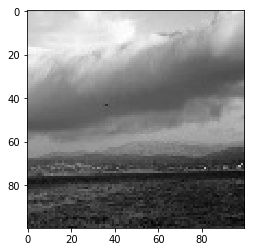

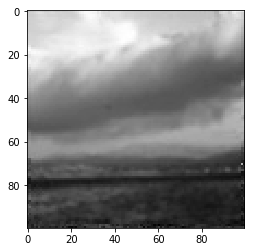

In [5]:
imgDirty = np.reshape(y_train[1], (100, 100)) * 255.0
imgClean = np.reshape(x_train[1], (100, 100)) * 255.0

plt.figure()
plt.imshow(imgDirty, cmap='gray',interpolation='none')

plt.figure()
plt.imshow(imgClean, cmap='gray',interpolation='none')



In [6]:
model = Sequential()
model.add( Input(shape = (100, 100, 1)) )

# encoder part
model.add( Conv2D(64, (3, 3), activation = 'relu', padding = 'same') )
model.add( MaxPooling2D((2, 2), padding = 'same'))

# decoder part
model.add( Conv2D(64, (3, 3), activation = 'relu', padding = 'same') )
model.add( UpSampling2D((2, 2)) )

# output
model.add( Conv2D(1, (3, 3), activation='sigmoid', padding='same') )

model.compile( loss = 'mse', optimizer = K.optimizers.Adam(lr=0.001) )
model.build()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = K.callbacks.EarlyStopping(monitor = 'val_loss',
                                           min_delta = 0,
                                           patience = 5,
                                           verbose = 1, 
                                           mode = 'auto'
                                           )
history = model.fit(x_train, y_train,
                   batch_size = 20,
                   epochs = 200,
                   validation_data=(x_test, x_test),
                   callbacks = [early_stopping]
                   )
        
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Train on 2000 samples, validate on 0 samples
Epoch 1/200
1200/2000 [=================>............] - ETA: 36s - loss: 0.0236

In [ ]:
preds = model.predict(x_test)
preds_0 = preds[0] * 255.0
preds_0 = preds_0.reshape(258, 540)
plt.imshow(preds_0, cmap='gray')
